In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HSON    1259 non-null   float64
 1   ISSC    1259 non-null   float64
 2   KRNT    1259 non-null   float64
 3   RCII    1259 non-null   float64
 4   SAIA    1259 non-null   float64
 5   AMD     1259 non-null   float64
 6   EPAM    1259 non-null   float64
 7   ASML    1259 non-null   float64
 8   AUDC    1259 non-null   float64
 9   DSGX    1259 non-null   float64
 10  MGIC    1259 non-null   float64
 11  DHI     1259 non-null   float64
 12  LULU    1259 non-null   float64
 13  MBUU    1259 non-null   float64
 14  MCRI    1259 non-null   float64
 15  RUSHA   1259 non-null   float64
 16  CTLT    1259 non-null   float64
 17  IDXX    1259 non-null   float64
 18  BDSI    1259 non-null   float64
 19  MEDP    1259 non-null   float64
 20  MODV    1259 non-null   float64
 21  RGEN    1259 non-nu

## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Close']
    save_dataframe_to_csv('close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('close', ticker)
    add_daily_return_to_df('close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('close', x)
    
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX']

#add in the weightage of stocks
port_shares = [0.007181667,0.002898889,0.011983333,0.007311111,0.026180556,0.006376111,0.013810556,
               0.014952778,0.008921667,0.008227222,0.003267778,0.01,0.031030556,0.0057,0.001186111,
               0.007639444,0.000592222,0.02066,0.004065,0.005232778,0.005361667,0.019643889,0.016286667,
               0.022943333,0.016325556,0.015356111,0.040199444,0.055555556,0.055555556,0.004451667,0.051103889,0.5]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.101980,0.010088,0.158779,0.085101,1.175507,0.072879,0.879180,1.651534,0.058794,0.174828,...,0.131584,0.211607,2.396289,5.862778,2.811667,0.016382,0.434383,0.9720,24.930908,NaN
2017-01-04,0.105571,0.010175,0.154585,0.085979,1.179434,0.072879,0.888847,1.643609,0.058080,0.176474,...,0.124074,0.227731,2.462216,5.871111,2.837778,0.017495,0.433872,0.9735,25.165524,0.009411
2017-01-05,0.104852,0.010494,0.149792,0.081958,1.150635,0.071667,0.894234,1.663347,0.056117,0.174006,...,0.117217,0.224506,2.448146,5.793333,2.829444,0.017362,0.436938,0.9315,24.978841,-0.007418
2017-01-06,0.103416,0.010436,0.151589,0.078594,1.174983,0.072178,0.923512,1.661553,0.057188,0.174828,...,0.117054,0.228806,2.423625,5.751111,2.818889,0.017139,0.431317,0.9610,25.004278,0.001018
2017-01-09,0.100543,0.010871,0.159978,0.079033,1.154562,0.073262,0.923098,1.682038,0.056296,0.174417,...,0.115911,0.225428,2.397495,5.721667,2.758889,0.017629,0.435405,0.9405,24.824657,-0.007184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.200009,0.018582,1.837764,0.359707,8.719434,0.984216,9.625958,12.133133,0.310920,0.673151,...,0.414506,0.644803,4.689265,21.297777,4.067222,0.082801,5.005626,0.6260,111.564613,0.022463
2021-12-28,0.202379,0.019133,1.826859,0.357733,8.644558,0.976501,9.421561,12.033547,0.308779,0.674632,...,0.408955,0.644803,4.600826,21.373890,4.062222,0.080842,4.939191,0.6225,110.641311,-0.008276
2021-12-29,0.201518,0.018959,1.849987,0.360876,8.781220,0.945322,9.361348,11.991829,0.310563,0.678252,...,0.416465,0.644650,4.618514,21.386112,4.051111,0.080620,4.939191,0.6470,110.910916,0.002437


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.101980,0.010088,0.158779,0.085101,1.175507,0.072879,0.879180,1.651534,0.058794,0.174828,...,0.131584,0.211607,2.396289,5.862778,2.811667,0.016382,0.434383,0.9720,24.930908,NaN
2017-01-04,0.105571,0.010175,0.154585,0.085979,1.179434,0.072879,0.888847,1.643609,0.058080,0.176474,...,0.124074,0.227731,2.462216,5.871111,2.837778,0.017495,0.433872,0.9735,25.165524,0.009411
2017-01-05,0.104852,0.010494,0.149792,0.081958,1.150635,0.071667,0.894234,1.663347,0.056117,0.174006,...,0.117217,0.224506,2.448146,5.793333,2.829444,0.017362,0.436938,0.9315,24.978841,-0.007418
2017-01-06,0.103416,0.010436,0.151589,0.078594,1.174983,0.072178,0.923512,1.661553,0.057188,0.174828,...,0.117054,0.228806,2.423625,5.751111,2.818889,0.017139,0.431317,0.9610,25.004278,0.001018
2017-01-09,0.100543,0.010871,0.159978,0.079033,1.154562,0.073262,0.923098,1.682038,0.056296,0.174417,...,0.115911,0.225428,2.397495,5.721667,2.758889,0.017629,0.435405,0.9405,24.824657,-0.007184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.200009,0.018582,1.837764,0.359707,8.719434,0.984216,9.625958,12.133133,0.310920,0.673151,...,0.414506,0.644803,4.689265,21.297777,4.067222,0.082801,5.005626,0.6260,111.564613,0.022463
2021-12-28,0.202379,0.019133,1.826859,0.357733,8.644558,0.976501,9.421561,12.033547,0.308779,0.674632,...,0.408955,0.644803,4.600826,21.373890,4.062222,0.080842,4.939191,0.6225,110.641311,-0.008276
2021-12-29,0.201518,0.018959,1.849987,0.360876,8.781220,0.945322,9.361348,11.991829,0.310563,0.678252,...,0.416465,0.644650,4.618514,21.386112,4.051111,0.080620,4.939191,0.6470,110.910916,0.002437


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,ASML,AUDC,DSGX,...,TBBK,FCX,NUE,SBAC,COP,QNST,TTGT,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.101980,0.010088,0.158779,0.085101,1.175507,0.072879,0.879180,1.651534,0.058794,0.174828,...,0.131584,0.211607,2.396289,5.862778,2.811667,0.016382,0.434383,0.9720,24.930908,NaN
2017-01-04,0.105571,0.010175,0.154585,0.085979,1.179434,0.072879,0.888847,1.643609,0.058080,0.176474,...,0.124074,0.227731,2.462216,5.871111,2.837778,0.017495,0.433872,0.9735,25.165524,0.009411
2017-01-05,0.104852,0.010494,0.149792,0.081958,1.150635,0.071667,0.894234,1.663347,0.056117,0.174006,...,0.117217,0.224506,2.448146,5.793333,2.829444,0.017362,0.436938,0.9315,24.978841,-0.007418
2017-01-06,0.103416,0.010436,0.151589,0.078594,1.174983,0.072178,0.923512,1.661553,0.057188,0.174828,...,0.117054,0.228806,2.423625,5.751111,2.818889,0.017139,0.431317,0.9610,25.004278,0.001018
2017-01-07,0.103416,0.010436,0.151589,0.078594,1.174983,0.072178,0.923512,1.661553,0.057188,0.174828,...,0.117054,0.228806,2.423625,5.751111,2.818889,0.017139,0.431317,0.9610,25.004278,0.001018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.200009,0.018582,1.837764,0.359707,8.719434,0.984216,9.625958,12.133133,0.310920,0.673151,...,0.414506,0.644803,4.689265,21.297777,4.067222,0.082801,5.005626,0.6260,111.564613,0.022463
2021-12-28,0.202379,0.019133,1.826859,0.357733,8.644558,0.976501,9.421561,12.033547,0.308779,0.674632,...,0.408955,0.644803,4.600826,21.373890,4.062222,0.080842,4.939191,0.6225,110.641311,-0.008276
2021-12-29,0.201518,0.018959,1.849987,0.360876,8.781220,0.945322,9.361348,11.991829,0.310563,0.678252,...,0.416465,0.644650,4.618514,21.386112,4.051111,0.080620,4.939191,0.6470,110.910916,0.002437


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','ASML',
          'AUDC','DSGX','MGIC','DHI','LULU','MBUU','MCRI','RUSHA',
          'CTLT','IDXX','BDSI','MEDP','MODV','RGEN','TROW','CG',
          'TBBK','FCX','NUE','SBAC','COP','QNST','TTGT','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2017-01-03,24.930908
2017-01-04,25.165524
2017-01-05,24.978841
2017-01-06,25.004278
2017-01-07,25.004278
...,...
2021-12-27,111.564613
2021-12-28,110.641311
2021-12-29,110.910916


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


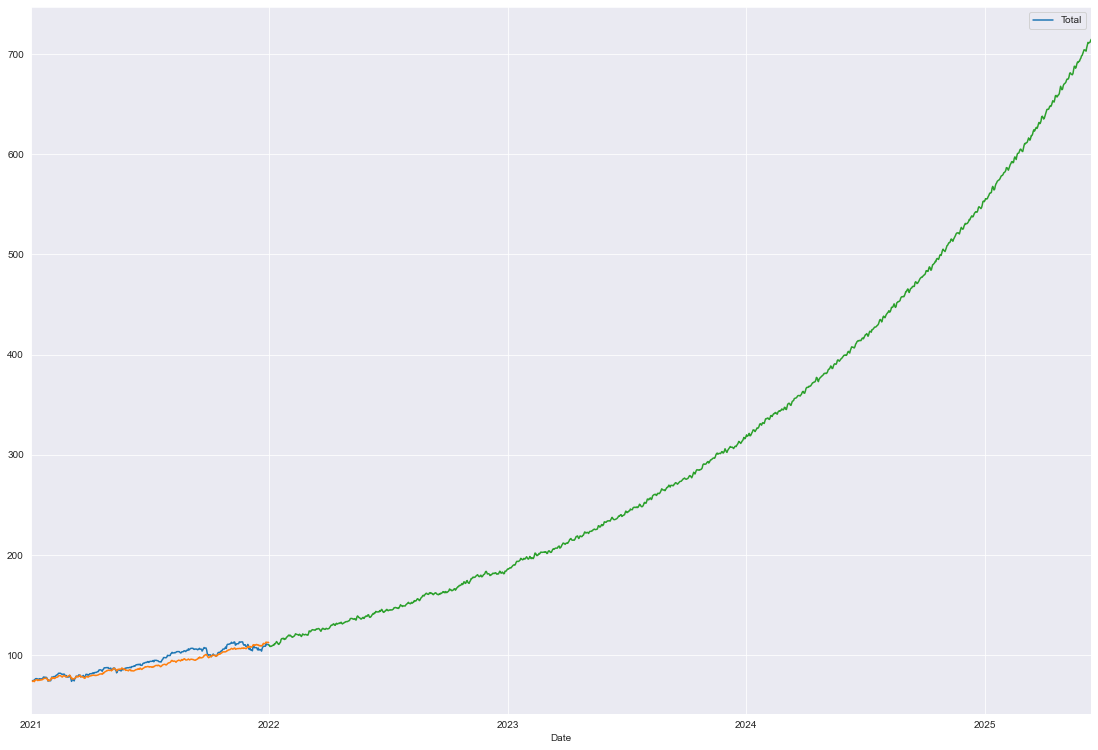

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2021-12-31    110.455551
2022-01-01    109.851314
2022-01-02    108.800939
2022-01-03    109.041052
2022-01-04    109.027397
                 ...    
2025-06-09    711.074779
2025-06-10    711.272722
2025-06-11    711.668896
2025-06-12    713.368242
2025-06-13    714.714807
Freq: D, Length: 1261, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2021-12-31,110.455551
2022-01-01,109.851314
2022-01-02,108.800939
2022-01-03,109.041052
2022-01-04,109.027397
...,...
2025-06-09,711.074779
2025-06-10,711.272722
2025-06-11,711.668896
2025-06-12,713.368242


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.005470
2022-01-02,-0.014980
2022-01-03,-0.012806
2022-01-04,-0.012930
...,...
2025-06-09,5.437655
2025-06-10,5.439447
2025-06-11,5.443034
2025-06-12,5.458419


In [26]:
#calculate annualized volatility
annualized_vol = np.sqrt(np.log(forecast / forecast.shift(1)).var()) * np.sqrt(252)
annualized_vol*100

6.2636908350247085